# Bootstrap Examples

_This setup code is required to run in an IPython notebook_

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 6.0)
pylab.rcParams['savefig.dpi'] = 90

try:
    import seaborn
except ImportError:
    pass

Populating the interactive namespace from numpy and matplotlib


## Sharpe Ratio

The Sharpe Ratio is an important measure of return per unit of risk.  The example shows how to estimate the variance of the Sharpe Ratio and how to construct confidence intervals for the Sharpe Ratio using a long series of U.S. equity data.  First, the data is imported using pandas.

In [2]:
import numpy as np
import pandas as pd
import pandas.io.data as web
ff=web.DataReader('F-F_Research_Data_Factors_TXT', 'famafrench')
ff = ff[0]


The data set contains the Fama-French factors, including the excess market reutrn.

In [3]:
ff.describe()
excess_market = ff[['1 Mkt-RF']]


The next step is to construct a function that computes the Sharpe Ratio.  This function also return the annualized mean and annualized standard deviation which will allow the covariance matrix of these parameters to be estimated using the bootstrap.

In [4]:
def sharpe_ratio(x):
    mu, sigma = 12 * x.mean(), np.sqrt(12 * x.var())
    values = np.array([mu, sigma, mu / sigma ]).squeeze()
    index = ['mu', 'sigma', 'SR']
    return pd.Series(values, index=index)


The function can be called directly on the data to shwo full sample estimates.

In [5]:
params = sharpe_ratio(excess_market)
params

mu        7.834140
sigma    18.697578
SR        0.418992
dtype: float64

### _Warning_

_The bootstrap chosen must be appropriate for the data.  Squared returns are serially correlated, and so a time-series bootstrap is required._

Bootstraps are initialized with any bootstrap specific parameters and the data to be used in the bootstrap.  Here the `12` is the average window length in the Stationary Bootstrap, and the next input is the data to be bootstrapped.

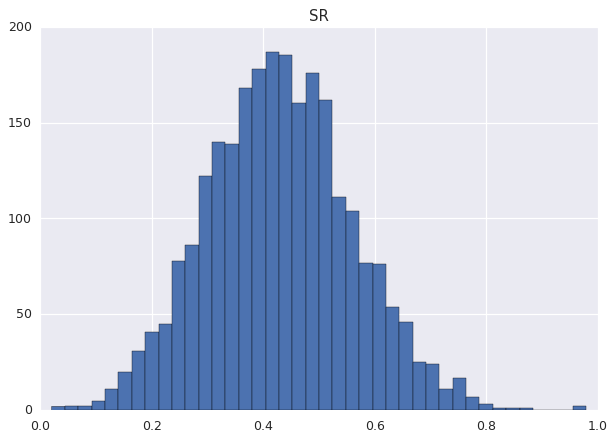

In [6]:
from arch.bootstrap import StationaryBootstrap
bs = StationaryBootstrap(12, excess_market)
results = bs.apply(sharpe_ratio, 2500)
SR = pd.DataFrame(results[:,-1:], columns=['SR'])
fig = SR.hist(bins=40)

In [7]:
cov = bs.cov(sharpe_ratio, 1000)
cov = pd.DataFrame(cov, index=params.index, columns=params.index)
print(cov)
se = pd.Series(np.sqrt(np.diag(cov)), index=params.index)
se.name = 'Std Errors'
print('\n')
print(se)

             mu     sigma        SR
mu     4.315708 -0.636594  0.245646
sigma -0.636594  3.138060 -0.104996
SR     0.245646 -0.104996  0.015705


mu       2.077428
sigma    1.771457
SR       0.125321
Name: Std Errors, dtype: float64


In [8]:
ci = bs.conf_int(sharpe_ratio, 1000, method='basic')
ci = pd.DataFrame(ci, index=['Lower','Upper'], columns=params.index)
print(ci)

              mu      sigma        SR
Lower   3.918485  15.338137  0.153562
Upper  12.097401  21.808158  0.652283


Alternative confidence intervals can be computed using a variety of methods.  Setting `reuse=True` allows the previous bootstrap results to be used when constructing confidence intervals using alternative methods.

In [9]:
ci = bs.conf_int(sharpe_ratio, 1000, method='percentile', reuse=True)
ci = pd.DataFrame(ci, index=['Lower','Upper'], columns=params.index)
print(ci)

              mu      sigma        SR
Lower   3.570879  15.586998  0.185701
Upper  11.749795  22.057019  0.684423


## Probit (Statsmodels)

The second example makes use of a Probit model from Statsmodels.  The demo data is university admissions data which contains a binary variable for being admitted, GRE score, GPA score and quartile rank. This data is downloaded from the internet and imported using pandas.

In [10]:
import numpy as np
import pandas as pd
import urllib2
import StringIO
url = 'http://www.ats.ucla.edu/stat/stata/dae/binary.dta'
file_name = url.split('/')[-1]

u = urllib2.urlopen(url)
f = open(file_name, 'wb')
block_sz = 8192
while True:
    buffer = u.read(block_sz)
    if not buffer:
        break

    f.write(buffer)

f.close()
binary = pd.read_stata(file_name)
binary = binary.dropna()
print(binary.describe())

            admit         gre         gpa       rank
count  400.000000  400.000000  400.000000  400.00000
mean     0.317500  587.700000    3.389900    2.48500
std      0.466087  115.516536    0.380567    0.94446
min      0.000000  220.000000    2.260000    1.00000
25%      0.000000  520.000000    3.130000    2.00000
50%      0.000000  580.000000    3.395000    2.00000
75%      1.000000  660.000000    3.670000    3.00000
max      1.000000  800.000000    4.000000    4.00000


### Fitting the model directly

The first steps are to build the regressor and the dependent variable arrays.  Then, using these arrays, the model can be estimated by calling `fit`

In [11]:
endog = binary[['admit']]
exog = binary[['gre','gpa']]
const = pd.Series(np.ones(exog.shape[0]), index=endog.index)
const.name = 'Const'
exog = pd.DataFrame([const, exog.gre, exog.gpa]).T
# Estimate the model
import statsmodels.api as sm
mod = sm.Probit(endog, exog)
fit = mod.fit(disp=0)
params = fit.params
print(params)

Const   -3.003536
gre      0.001643
gpa      0.454575
dtype: float64


### The wrapper function

Most models in Statsmodels are implemented as classes, require an explicit call to `fit` and return a class containing parameter estimates and other quantities.  These classes cannot be directly used with the bootstrap methods.  However, a simple wrapper can be written that takes the data as the only inputs and returns parameters estimated using a Statsmodel model.

In [12]:
def probit_wrap(endog, exog):
    return sm.Probit(endog, exog).fit(disp=0).params


A call to this function should return the same parameter values.

In [13]:
probit_wrap(endog, exog)

Const   -3.003536
gre      0.001643
gpa      0.454575
dtype: float64

The wrapper can be directly used to estimate the parameter covariance or to construct confidence intervals.

In [14]:
from arch.bootstrap import IIDBootstrap 
bs = IIDBootstrap(endog=endog, exog=exog)
cov = bs.cov(probit_wrap, 1000)
cov = pd.DataFrame(cov, index=exog.columns, columns=exog.columns)
print(cov)

          Const       gre       gpa
Const  0.421243 -0.000073 -0.108926
gre   -0.000073  0.000000 -0.000057
gpa   -0.108926 -0.000057  0.041840


In [15]:
se = pd.Series(np.sqrt(np.diag(cov)), index=exog.columns)
print(se)
print('T-stats')
print(params / se)

Const    0.649033
gre      0.000666
gpa      0.204548
dtype: float64
T-stats
Const   -4.627712
gre      2.466545
gpa      2.222334
dtype: float64


In [16]:
ci = bs.conf_int(probit_wrap, 1000, method='basic')
ci = pd.DataFrame(ci, index=['Lower','Upper'], columns=exog.columns)
print(ci)

          Const       gre       gpa
Lower -4.205556  0.000342  0.061011
Upper -1.699274  0.002934  0.829515


### Speeding things up

Starting values can be provided to `fit` which can save time finding starting values.  Since the bootstrap parameter estimates should be close to the original sample estimates, the full sample estimated parameters are reasonable starting values.  These can be passed using the `extra_kwargs` dictionary to a modified wrapper that will accept a keyword argument containing starting values.

In [17]:
def probit_wrap_start_params(endog, exog, start_params=None):
    return sm.Probit(endog, exog).fit(start_params=start_params, disp=0).params

In [18]:
bs.reset()  # Reset to original state for comparability
cov = bs.cov(probit_wrap_start_params, 1000, extra_kwargs={'start_params': params.values})
cov = pd.DataFrame(cov, index=exog.columns, columns=exog.columns)
print(cov)

          Const       gre       gpa
Const  0.421243 -0.000073 -0.108926
gre   -0.000073  0.000000 -0.000057
gpa   -0.108926 -0.000057  0.041840
